# **TREES**

this script is for setup, execution, and analysis of the different algorithms that use decision trees

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import funcs as f
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
'''
Import data from data_organization.ipynb and set random seed

'''

df_all = pd.read_csv('../data/df_all.csv').drop('Unnamed: 0', axis = 1)
df_gus = pd.read_csv('../data/df_gus.csv').drop('Unnamed: 0', axis = 1)
df_tgus = pd.read_csv('../data/df_tgus.csv').drop('Unnamed: 0', axis = 1)
df_tgus_st = pd.read_csv('../data/df_tgus*.csv').drop('Unnamed: 0', axis = 1)
df_raw = pd.read_csv('../data/df_raw.csv').drop('Unnamed: 0', axis = 1)

#tree test
#df_all = pd.read_csv('../data/df_tree_test.csv').drop('Unnamed: 0', axis = 1)

np.random.seed(8)

## **bagging**


In [36]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

# Random trees are usually used just in ensemble methods
# so we have to manually specify we only want one to start
#random_tree = ExtraTreesClassifier(n_estimators = 1, bootstrap=True)
random_tree = DecisionTreeClassifier()


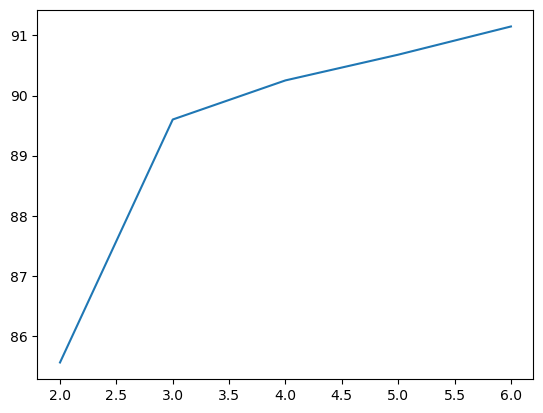

In [37]:
'''
IMPORTANT CONCEPT:

- need to hypertune tree...find best depth

- from inspection, fitting the DecisionTreeClassifier without a max depth on all X and Y results in tree depth of 6...so test from 2-6

- cross-validation at each depth is done on 100 different random training sets and the average accuracy at each is recorded

- as graph shows, a max depth of 6 results in the overall best accuracy

'''

#set train and test data
df_all=df_all.sample(frac=1) 
train_proportion = 0.8 
n = len(df_all)
t = int(train_proportion * n)

# separate training and test sets
y = df_all['detected']
X = df_all.loc[:, ~df_all.columns.isin(['detected'])]

#features in training set
train_x = X.iloc[:t,:].reset_index().iloc[:,1:]
#features in test set
test_x = X.iloc[t:,:].reset_index().iloc[:,1:]
#targets in train set
train_y = pd.Series(y[:t].reset_index().iloc[:,1:].iloc[:,0])
#targets in test set
test_y = pd.Series(y[t:].reset_index().iloc[:,1:].iloc[:,0])

# define the depths
depths = np.arange(2,7)
# create an empty data frame for our results
results = [0,0,0,0,0] 

for i in range(100):
    for j in range(len(depths)):
        best_depth_tree = DecisionTreeClassifier(max_depth = depths[j]) # creating an instance of a decision tree
        results[j%5] += cross_val_score(best_depth_tree, train_x, 
                                    train_y, scoring="accuracy", # getting the cv accuracy metric for the tree at each depth
                    cv=6).mean()
        #results.append(cross_val_score(best_depth_tree, train_x, train_y, scoring="accuracy", cv=6).mean())# getting the cv accuracy metric for the tree at each depth
                        

test = pd.DataFrame({'depths':depths, 'accuracy':results})
test.sort_values("accuracy", ascending=False)
plt.plot(test.depths, test.accuracy)

In [62]:
# define tree
clf_tree = DecisionTreeClassifier(max_depth = 6)

# define bagging classifier
clf = BaggingClassifier(base_estimator = clf_tree,
                                        n_estimators = 100, bootstrap = True
                                       )

In [99]:
'''
Considering GUS, TGUS,  TGUS*, and raw values with other features

'''
all_train =[]
all_vals =[]
all_tests=[]
for i in range(100):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_all, clf, 'bagging')
    all_train = np.append(train_acc, all_train)
    all_vals = np.append(val_acc, all_vals)
    all_tests = np.append(test_acc, all_tests)

    # keep best model
    if test_acc >= np.max(all_tests):
        all_model = model
        all_train_acc = train_acc
        all_val_acc = val_acc
        all_test_acc = test_acc

print('All - Results:')
print(f'Best Scenario Training Accuracy: {all_train_acc}%')
print(f'Average Training Accuracy: {round(np.mean(all_train),1)}%')
print(f'Best Scenario Validation Accuracy: {all_val_acc}%')
print(f'Average Validation Accuracy: {round(np.mean(all_vals),1)}%')
print(f'Best Scenario Test Accuracy: {all_test_acc}%')
print(f'Average Test Accuracy: {round(np.mean(all_tests),1)}%')

All - Results:
Best Scenario Training Accuracy: 95.0%
Average Training Accuracy: 95.4%
Best Scenario Validation Accuracy: 95.7%
Average Validation Accuracy: 96.8%
Best Scenario Test Accuracy: 97.2%
Average Test Accuracy: 92.7%


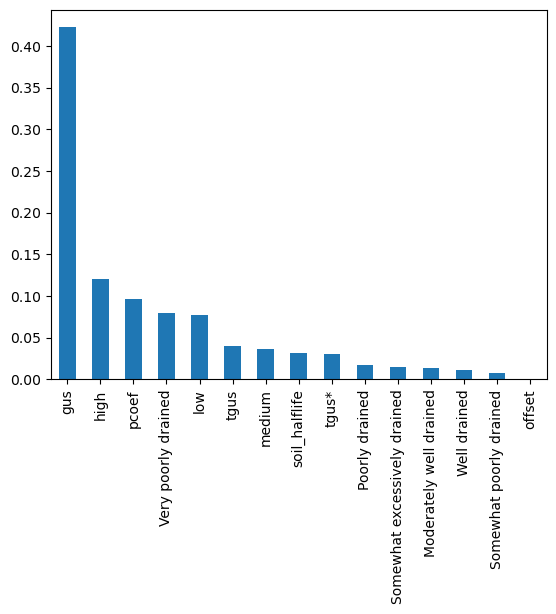

In [100]:
feature_importances_all = np.mean([
    tree.feature_importances_ for tree in all_model.estimators_
], axis=0)

fi_all = pd.Series(feature_importances_all, index = df_all.drop('detected', axis = 1).columns)

fi_all = fi_all.sort_values(ascending=False)
ax = fi_all.plot(kind='bar')

In [72]:
'''
Considering just GUS with other features

'''
gus_model, gus_train_acc, gus_val_acc, gus_test_acc = f.kfold_crossval(df_gus, clf, 'bagging')
print('GUS - Results:')
print(f'Best Training Accuracy: {gus_train_acc}%')
print(f'Best Validation Accuracy: {gus_val_acc}%')
print(f'Test Accuracy: {gus_test_acc}%\n')

GUS - Results:
Best Training Accuracy: 95.0%
Best Validation Accuracy: 95.7%
Test Accuracy: 91.5%



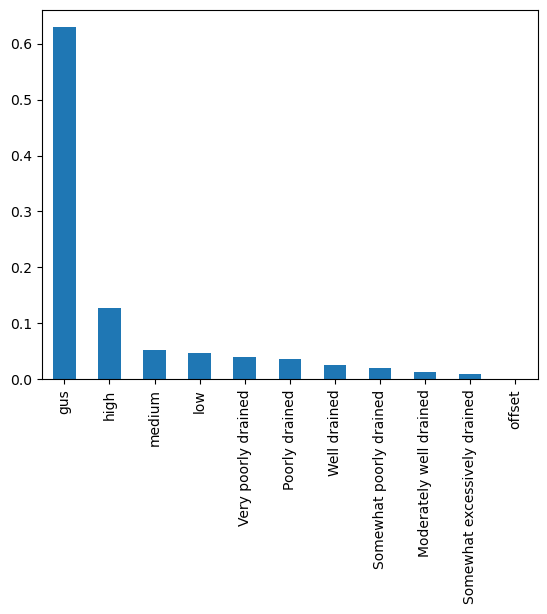

In [73]:
feature_importances_gus = np.mean([
    tree.feature_importances_ for tree in gus_model.estimators_
], axis=0)

fi_gus = pd.Series(feature_importances_gus, index = df_gus.drop('detected', axis = 1).columns)

fi_gus = fi_gus.sort_values(ascending=False)
ax = fi_gus.plot(kind='bar')

In [87]:
'''
Considering just TGUS with other features

'''
tgus_model, tgus_train_acc, tgus_val_acc, tgus_test_acc = f.kfold_crossval(df_tgus, clf, 'bagging')
print('TGUS - Results:')
print(f'Best Training Accuracy: {tgus_train_acc}%')
print(f'Best Validation Accuracy: {tgus_val_acc}%')
print(f'Test Accuracy: {tgus_test_acc}%\n')

TGUS - Results:
Best Training Accuracy: 95.0%
Best Validation Accuracy: 97.2%
Test Accuracy: 95.3%



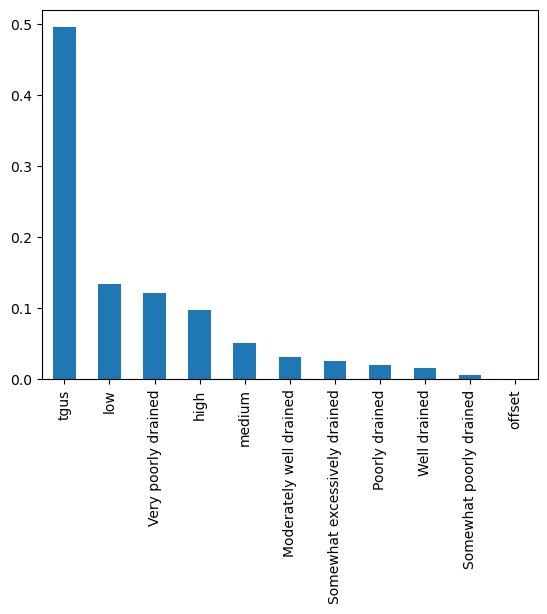

In [77]:
feature_importances_tgus = np.mean([
    tree.feature_importances_ for tree in tgus_model.estimators_
], axis=0)

fi_tgus = pd.Series(feature_importances_tgus, index = df_tgus.drop('detected', axis = 1).columns)

fi_tgus = fi_tgus.sort_values(ascending=False)
ax = fi_tgus.plot(kind='bar')

In [82]:
'''
Considering just TGUS* and raw values with other features

'''
tgus_st_model, tgus_st_train_acc, tgus_st_val_acc, tgus_st_test_acc = f.kfold_crossval(df_tgus_st, clf, 'bagging')
print('TGUS* - Results:')
print(f'Best Training Accuracy: {tgus_st_train_acc}%')
print(f'Best Validation Accuracy: {tgus_st_val_acc}%')
print(f'Test Accuracy: {tgus_st_test_acc}%\n')

TGUS* - Results:
Best Training Accuracy: 95.0%
Best Validation Accuracy: 98.6%
Test Accuracy: 92.5%



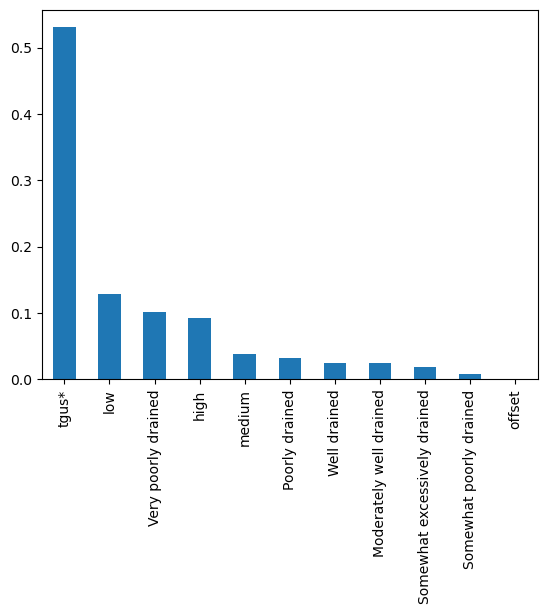

In [83]:
feature_importances_tgus_st = np.mean([
    tree.feature_importances_ for tree in tgus_st_model.estimators_
], axis=0)

fi_tgus_st = pd.Series(feature_importances_tgus_st, index = df_tgus_st.drop('detected', axis = 1).columns)

fi_tgus_st = fi_tgus_st.sort_values(ascending=False)
ax = fi_tgus_st.plot(kind='bar')

In [88]:
'''
Considering just raw values with other features

'''
raw_model, raw_train_acc, raw_val_acc, raw_test_acc = f.kfold_crossval(df_raw, clf, 'bagging')
print('Raw - Results:')
print(f'Best Training Accuracy: {raw_train_acc}%')
print(f'Best Validation Accuracy: {raw_val_acc}%')
print(f'Test Accuracy: {raw_test_acc}%\n')

Raw - Results:
Best Training Accuracy: 96.0%
Best Validation Accuracy: 97.1%
Test Accuracy: 92.5%



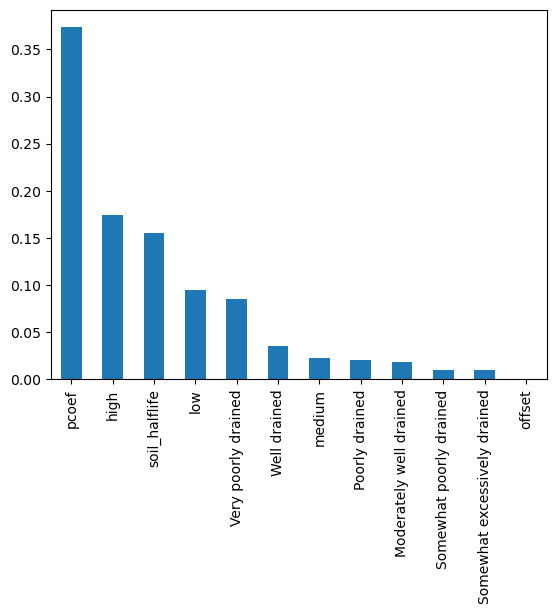

In [89]:
feature_importances_raw = np.mean([
    tree.feature_importances_ for tree in raw_model.estimators_
], axis=0)

fi_raw = pd.Series(feature_importances_raw, index = df_raw.drop('detected', axis = 1).columns)

fi_raw = fi_raw.sort_values(ascending=False)
ax = fi_raw.plot(kind='bar')

In [10]:

random_tree.fit(X,y)
random_tree.get_depth()
random_tree.feature_names_in_
random
#print(random_tree.feature_importances_)



array(['Moderately well drained', 'Poorly drained',
       'Somewhat excessively drained', 'Somewhat poorly drained',
       'Very poorly drained', 'Well drained', 'high', 'low', 'medium',
       'gus', 'tgus', 'tgus*', 'soil_halflife', 'pcoef', 'detlimit',
       'offset'], dtype=object)

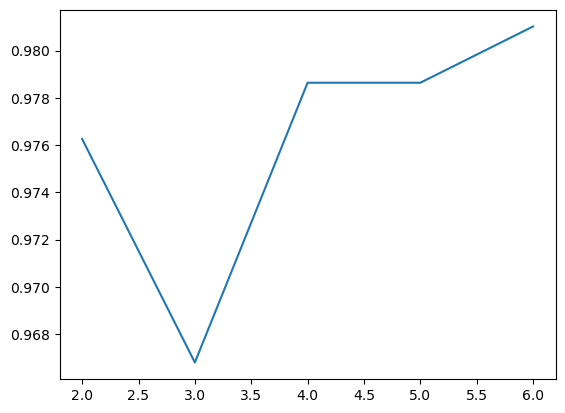